In [1]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn.metrics import mean_absolute_error
from math import sqrt

In [54]:
bitcoin_data_df = pd.read_csv('bitcoin_final_data_2.csv',index_col=0)

In [55]:
bitcoin_roll_price_df = pd.read_csv('rolling_mean_prc.csv',index_col=0)

In [56]:
final_df = pd.merge(bitcoin_data_df,bitcoin_roll_price_df,how='inner',left_index=True,right_index=True)

In [57]:
final_df.tail()

,Open Price,Close Price,High Price,Low Price,Positive Count,Neutral Count,Negative Count,Total Count,Positive Percentage,Neutral Percentage,Negative Percentage,Search Interest,Roll Mean High Price
Date,,,,,,,,,,,,,
2018-03-07,10803.900391,9965.570313,10929.500000,9692.120117,7550,19300,1063,27913,27.048329,69.143410,3.808261,15.81,11345.114118
2018-03-08,9951.440430,9395.009766,10147.400391,9335.870117,1710,4650,229,6589,25.952345,70.572166,3.475489,14.62,11215.842773
2018-03-09,9414.690430,9337.549805,9466.349609,8513.030273,6933,18847,974,26754,25.913882,70.445541,3.640577,16.66,10969.749860
2018-03-10,9350.589844,8866.000000,9531.320313,8828.469727,6116,15344,819,22279,27.451860,68.872032,3.676108,11.90,10684.481306
2018-03-11,8852.780273,9578.629883,9711.889648,8607.120117,6060,14826,787,21673,27.961058,68.407696,3.631246,11.73,10427.237026


In [58]:
final_df = final_df[['Positive Count','Negative Count','Neutral Count','Search Interest','Roll Mean High Price']]

In [59]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [60]:
final_df.head()

,Positive Count,Negative Count,Neutral Count,Search Interest,Roll Mean High Price
Date,,,,,
2017-01-01,1630,160,3410,2.64,963.986851
2017-01-02,2918,201,6669,4.86,980.873422
2017-01-03,3300,188,7648,4.44,995.735134
2017-01-04,861,65,1981,4.98,1021.949280
2017-01-05,2554,218,5795,6.00,1052.192566


In [61]:
final_df.tail()

,Positive Count,Negative Count,Neutral Count,Search Interest,Roll Mean High Price
Date,,,,,
2018-03-07,7550,1063,19300,15.81,11345.114118
2018-03-08,1710,229,4650,14.62,11215.842773
2018-03-09,6933,974,18847,16.66,10969.749860
2018-03-10,6116,819,15344,11.90,10684.481306
2018-03-11,6060,787,14826,11.73,10427.237026


In [62]:
final_df['Positive Count(t-1)'] = final_df['Positive Count'].shift(1)
final_df['Negative Count(t-1)'] = final_df['Negative Count'].shift(1)
final_df['Neutral Count(t-1)'] = final_df['Neutral Count'].shift(1)
final_df['Search Interest(t-1)'] = final_df['Search Interest'].shift(1)
final_df['Roll Mean High Price(t-1)'] = final_df['Roll Mean High Price'].shift(1)

In [63]:
final_df.head()

,Positive Count,Negative Count,Neutral Count,Search Interest,Roll Mean High Price,Positive Count(t-1),Negative Count(t-1),Neutral Count(t-1),Search Interest(t-1),Roll Mean High Price(t-1)
Date,,,,,,,,,,
2017-01-01,1630,160,3410,2.64,963.986851,NaN,NaN,NaN,NaN,NaN
2017-01-02,2918,201,6669,4.86,980.873422,1630.0,160.0,3410.0,2.64,963.986851
2017-01-03,3300,188,7648,4.44,995.735134,2918.0,201.0,6669.0,4.86,980.873422
2017-01-04,861,65,1981,4.98,1021.949280,3300.0,188.0,7648.0,4.44,995.735134
2017-01-05,2554,218,5795,6.00,1052.192566,861.0,65.0,1981.0,4.98,1021.949280


In [64]:
final_df.isnull().sum(axis = 0)

Positive Count               0
Negative Count               0
Neutral Count                0
Search Interest              0
Roll Mean High Price         0
Positive Count(t-1)          1
Negative Count(t-1)          1
Neutral Count(t-1)           1
Search Interest(t-1)         1
Roll Mean High Price(t-1)    1
dtype: int64

In [65]:
final_df = final_df.dropna()

In [66]:
final_df.head()

,Positive Count,Negative Count,Neutral Count,Search Interest,Roll Mean High Price,Positive Count(t-1),Negative Count(t-1),Neutral Count(t-1),Search Interest(t-1),Roll Mean High Price(t-1)
Date,,,,,,,,,,
2017-01-02,2918,201,6669,4.86,980.873422,1630.0,160.0,3410.0,2.64,963.986851
2017-01-03,3300,188,7648,4.44,995.735134,2918.0,201.0,6669.0,4.86,980.873422
2017-01-04,861,65,1981,4.98,1021.949280,3300.0,188.0,7648.0,4.44,995.735134
2017-01-05,2554,218,5795,6.00,1052.192566,861.0,65.0,1981.0,4.98,1021.949280
2017-01-06,3082,246,8627,4.68,1062.803293,2554.0,218.0,5795.0,6.00,1052.192566


In [67]:
final_df = final_df[['Positive Count(t-1)','Negative Count(t-1)','Neutral Count(t-1)','Search Interest(t-1)','Roll Mean High Price(t-1)','Roll Mean High Price']]

In [68]:
final_df.head()

,Positive Count(t-1),Negative Count(t-1),Neutral Count(t-1),Search Interest(t-1),Roll Mean High Price(t-1),Roll Mean High Price
Date,,,,,,
2017-01-02,1630.0,160.0,3410.0,2.64,963.986851,980.873422
2017-01-03,2918.0,201.0,6669.0,4.86,980.873422,995.735134
2017-01-04,3300.0,188.0,7648.0,4.44,995.735134,1021.949280
2017-01-05,861.0,65.0,1981.0,4.98,1021.949280,1052.192566
2017-01-06,2554.0,218.0,5795.0,6.00,1052.192566,1062.803293


In [69]:
sarimax_model = SARIMAX(final_df['Roll Mean High Price'],order=(1,1,1),seasonal_order=(1,1,1,4),exog=final_df['Positive Count(t-1)'])

C:\ProgramData\Anaconda3\envs\research-test\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\envs\research-test\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [70]:
res = sarimax_model.fit(disp=False)

C:\ProgramData\Anaconda3\envs\research-test\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [71]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:              Roll Mean High Price   No. Observations:                  434
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 4)   Log Likelihood               -2491.507
Date:                           Sun, 14 Mar 2021   AIC                           4995.013
Time:                                   15:27:25   BIC                           5019.382
Sample:                               01-02-2017   HQIC                          5004.637
                                    - 03-11-2018                                         
Covariance Type:                             opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Positive Count(t-1)    -0.0026      0.001     -4.614      0.000      -0.004      -0.001
ar.L1                   0.7751      0.020     37.835      0.000       0.735       0.815
ma.L1                   0.4198      0.031     13.421      0.000       0.358       0.481
ar.S.L4                 0.1823      0.027      6.804      0.000       0.130       0.235
ma.S.L4                -1.0000      0.030    -33.704      0.000      -1.058      -0.942
sigma2               6219.0869   4.78e-06    1.3e+09      0.000    6219.087    6219.087
===================================================================================
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):              3120.61
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):             140.29   Skew:                             0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.93e+23. Standard errors may be unstable.
"""

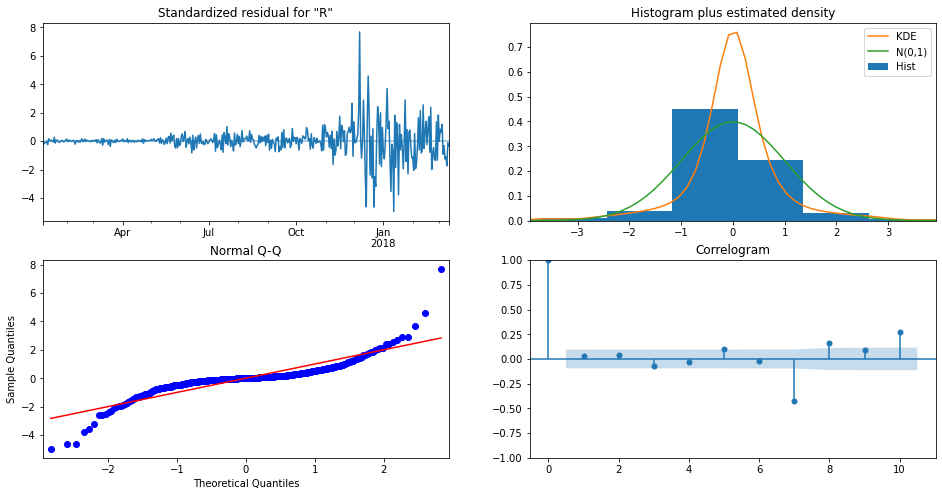

In [72]:
res.plot_diagnostics(figsize=(16,8))
plt.show()

In [73]:
forecast = res.get_prediction(start=pd.to_datetime('2018-02-06'),dyanmic=False)
predictions = forecast.predicted_mean

In [74]:
tr_start,tr_end = '2017-01-01','2017-02-05'
te_start,te_end = '2018-02-06','2018-03-11'
tra = final_df['Roll Mean High Price'][tr_start:tr_end].dropna()
tes = final_df['Roll Mean High Price'][te_start:te_end].dropna()

In [75]:
predictions

2018-02-06     9285.974786
2018-02-07     8857.757684
2018-02-08     8790.978857
2018-02-09     8513.797007
2018-02-10     8705.610451
2018-02-11     8590.603598
2018-02-12     8423.383993
2018-02-13     8825.031923
2018-02-14     8879.237992
2018-02-15     9057.168306
2018-02-16     9413.817799
2018-02-17     9608.129682
2018-02-18     9937.744813
2018-02-19    10462.037144
2018-02-20    10639.383397
2018-02-21    11258.199913
2018-02-22    11295.892381
2018-02-23    11273.680515
2018-02-24    11264.415025
2018-02-25    11064.662577
2018-02-26    10734.999455
2018-02-27    10794.634554
2018-02-28    10495.860581
2018-03-01    10644.141237
2018-03-02    10677.527289
2018-03-03    10826.435607
2018-03-04    11009.317698
2018-03-05    11352.406455
2018-03-06    11393.196698
2018-03-07    11445.094582
2018-03-08    11304.482178
2018-03-09    11107.764343
2018-03-10    10694.098951
2018-03-11    10454.375170
Freq: D, Name: predicted_mean, dtype: float64

In [76]:
tes

Date
2018-02-06     9256.262835
2018-02-07     8988.764369
2018-02-08     8741.617187
2018-02-09     8683.717215
2018-02-10     8639.688616
2018-02-11     8537.011440
2018-02-12     8625.737165
2018-02-13     8783.989956
2018-02-14     8928.194197
2018-02-15     9167.627093
2018-02-16     9394.358399
2018-02-17     9682.494141
2018-02-18    10073.018415
2018-02-19    10399.858399
2018-02-20    10828.434152
2018-02-21    11099.857003
2018-02-22    11214.756975
2018-02-23    11238.071289
2018-02-24    11160.599888
2018-02-25    10956.802734
2018-02-26    10842.688477
2018-02-27    10688.402762
2018-02-28    10641.445592
2018-03-01    10643.331334
2018-03-02    10743.574219
2018-03-03    10876.574219
2018-03-04    11103.628488
2018-03-05    11279.214146
2018-03-06    11368.014090
2018-03-07    11345.114118
2018-03-08    11215.842773
2018-03-09    10969.749860
2018-03-10    10684.481306
2018-03-11    10427.237026
Name: Roll Mean High Price, dtype: float64

In [77]:
actual = tes

In [78]:
act,pre = np.array(actual), np.array(predictions)
rmse = np.sqrt((pre-act) ** 2 ).mean()

In [79]:
act

array([ 9256.26283471,  8988.76436943,  8741.61718743,  8683.71721543,
        8639.68861614,  8537.01143986,  8625.73716529,  8783.98995557,
        8928.19419657,  9167.62709286,  9394.35839857,  9682.49414071,
       10073.01841529, 10399.85839857, 10828.43415186, 11099.85700343,
       11214.75697543, 11238.07128914, 11160.59988843, 10956.80273443,
       10842.68847657, 10688.40276229, 10641.44559157, 10643.33133386,
       10743.57421886, 10876.57421886, 11103.62848771, 11279.21414614,
       11368.01409029, 11345.11411814, 11215.84277329, 10969.74986029,
       10684.48130571, 10427.23702557])

In [80]:
rmse

85.35268341938557

In [81]:
rmse = sqrt(mean_squared_error(actual,predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 99.487


In [82]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [83]:
error_percentage = mape(actual,predictions)
print('MAE : ',error_percentage)

MAE :  0.845254981276324


In [84]:
np.array(actual)

array([ 9256.26283471,  8988.76436943,  8741.61718743,  8683.71721543,
        8639.68861614,  8537.01143986,  8625.73716529,  8783.98995557,
        8928.19419657,  9167.62709286,  9394.35839857,  9682.49414071,
       10073.01841529, 10399.85839857, 10828.43415186, 11099.85700343,
       11214.75697543, 11238.07128914, 11160.59988843, 10956.80273443,
       10842.68847657, 10688.40276229, 10641.44559157, 10643.33133386,
       10743.57421886, 10876.57421886, 11103.62848771, 11279.21414614,
       11368.01409029, 11345.11411814, 11215.84277329, 10969.74986029,
       10684.48130571, 10427.23702557])

In [85]:
from sklearn.metrics import mean_absolute_error
error_percentage = mean_absolute_error(actual,predictions)
print('MAE : ',error_percentage)

MAE :  85.35268341938557


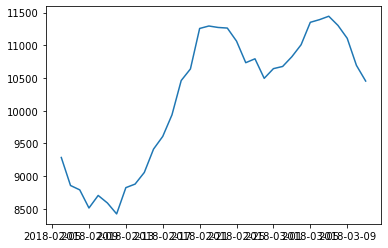

In [86]:
plt.plot(predictions)

In [87]:
predictions.index

DatetimeIndex(['2018-02-06', '2018-02-07', '2018-02-08', '2018-02-09',
               '2018-02-10', '2018-02-11', '2018-02-12', '2018-02-13',
               '2018-02-14', '2018-02-15', '2018-02-16', '2018-02-17',
               '2018-02-18', '2018-02-19', '2018-02-20', '2018-02-21',
               '2018-02-22', '2018-02-23', '2018-02-24', '2018-02-25',
               '2018-02-26', '2018-02-27', '2018-02-28', '2018-03-01',
               '2018-03-02', '2018-03-03', '2018-03-04', '2018-03-05',
               '2018-03-06', '2018-03-07', '2018-03-08', '2018-03-09',
               '2018-03-10', '2018-03-11'],
              dtype='datetime64[ns]', freq='D')

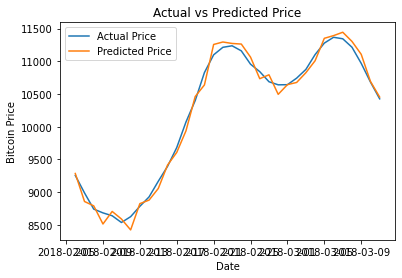

In [88]:
# line 1 points
x1 = predictions.index #[10,20,30]
y1 = act #[20,40,10]
# plotting the line 1 points 
plt.plot(x1, y1, label = "Actual Price")
# line 2 points
x2 = predictions.index #[10,20,30]
y2 = pre #[40,10,30]
# plotting the line 2 points 
plt.plot(x2, y2, label = "Predicted Price")
plt.xlabel('Date')
# Set the y axis label of the current axis.
plt.ylabel('Bitcoin Price')
# Set a title of the current axes.
plt.title('Actual vs Predicted Price')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [89]:
mae = mean_absolute_error(actual,predictions)

In [90]:
mae

85.35268341938557